In [1]:
# Decision tree algorithm from scratch using numpy and pandas
# i.e. without using the library scikit-learn

# Overview of the algorithm
# df = pd.read_csv("data.csv")

# train_df, test_df = train_test_split(df, test_size=0.2)
# tree = decision_tree_algorithm(train_df)
# accuracy = calculate_accuracy(test_df, tree)

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import random
from pprint import pprint

# Load and prepare data

###### Format of the Data
1. Last column of the data frame must contain the label and it must also be called "label"
2. There should be no missing values in the data frame

In [2]:
df = pd.read_csv('data/iris.csv')
df = df.drop("Id", axis=1)
df = df.rename(columns={"Species":"label"})
df.head()

,sepal_length,sepal_width,petal_length,petal_width,label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
# Make sure that there is no null values
# Notice there are 150 rows in all; 150 values in each of the column; so no null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
sepal_length    150 non-null float64
sepal_width     150 non-null float64
petal_length    150 non-null float64
petal_width     150 non-null float64
label           150 non-null object
dtypes: float64(4), object(1)
memory usage: 5.9+ KB


# Train-Test-Split

In [4]:
def train_test_split(df, test_size):
    if (isinstance(test_size, float)):
        test_size = round(test_size * len(df))

    indices = df.index.tolist()
    # Get random sample of requested size from population
    test_indices = random.sample(population=indices, k=test_size)

    # Prepare train and test data sets
    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    
    return train_df, test_df

In [5]:
df.index

RangeIndex(start=0, stop=150, step=1)

In [6]:
random.seed(0)
train_df, test_df = train_test_split(df, test_size=20)
data = train_df.values
data[:5]

array([[5.1, 3.5, 1.4, 0.2, 'Iris-setosa'],
       [4.9, 3.0, 1.4, 0.2, 'Iris-setosa'],
       [4.7, 3.2, 1.3, 0.2, 'Iris-setosa'],
       [4.6, 3.1, 1.5, 0.2, 'Iris-setosa'],
       [5.0, 3.6, 1.4, 0.2, 'Iris-setosa']], dtype=object)

### Data Pure?

In [7]:
# Check if the data has one class or more than one class
# if the data has only one class then it is pure otherwise it is not pure
def check_purity(data):
    label_column = data[:, -1]
    unique_classes = np.unique(label_column)
    
    if (len(unique_classes) == 1):
        return True
    else:
        return False

### Classify



In [8]:
# Test the node for max no. of data points of a class and return the class name
def classify_data(data):

    label_column = data[:, -1]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)
    
    # Get the index of the class that appear more in data
    index = counts_unique_classes.argmax()
    classification = unique_classes[index]    
    
    return classification

In [9]:
classify_data(train_df[(train_df.petal_width > 0.8) & (train_df.petal_width < 2)].values)

'Iris-versicolor'

### Potential Splits ?

In [10]:
def get_potential_splits(data):
    potential_splits = {}
    _, n_columns = data.shape # shape returns no. of rows, no. of cols; ignore rows, take cols

    # Process each column
    for column_index in range(n_columns - 1):
        potential_splits[column_index] = []
        values = data[:, column_index]
        unique_values = np.unique(values)

        for index in range(len(unique_values)):
            if index != 0:
                current_value = unique_values[index]
                previous_value = unique_values[index -1]
                potential_split = (current_value + previous_value)/2

                potential_splits[column_index].append(potential_split)
    return potential_splits


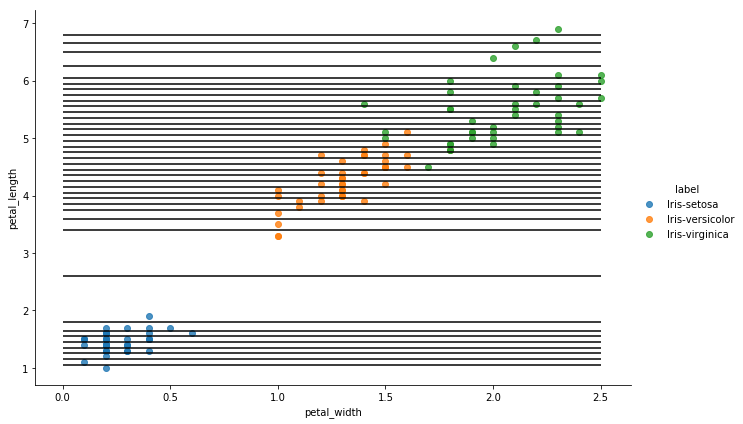

In [11]:
potential_splits = get_potential_splits(train_df.values)

sns.lmplot(data=train_df, x="petal_width", y="petal_length", hue="label", fit_reg=False, height=6, aspect=1.5)
# plt.vlines(x=potential_splits[3], ymin=1, ymax=7)
plt.hlines(y=potential_splits[2], xmin=0, xmax=2.5)

### Split Data

In [12]:
def split_data(data, split_column, split_value):
    split_column_values = data[:, split_column]
    
    data_below = data[split_column_values <= split_value]
    data_above = data[split_column_values >  split_value]
    
    return data_below, data_above

In [13]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


### Lowest Overall Entropy?

In [14]:
def calculate_entropy(data):
    
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)
    
    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
    
    return entropy

In [15]:
def calculate_overall_entropy(data_below, data_above):
    
    n_data_points = len(data_below) + len(data_above)
    
    p_data_below = len(data_below) / n_data_points
    p_data_above = len(data_above) / n_data_points
    
    overall_entropy = (p_data_below * calculate_entropy(data_below)
                      +p_data_above * calculate_entropy(data_above))
    
    return overall_entropy

In [16]:
def determine_best_split(data, potential_splits):
    overall_entropy = 999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_overall_entropy(data_below, data_above)
            
            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value
                
    return best_split_column, best_split_value

### Decision Tree Algorithm

In [17]:
example_tree = {"petal_width <= 0.8": ["Iris-setosa", 
                                      {"petal_width <= 1.65": [{"petal_length <= 4.9": ["Iris-versicolor",
                                                                                        "Iris-verginica"]},
                                                                "Iris-virginica"]}]}

In [18]:
def decision_tree_algorithm(df, counter=0, min_samples=2, max_depth=5):
    
    # data preparation
    if counter == 0:
        global COLUMN_HEADERS
        COLUMN_HEADERS = df.columns
        data = df.values
    else:
        data = df
        
    # base cases
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)
        return classification
    
    # recursive part
    else:
        counter += 1
        
        # helper functions
        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above =  split_data(data, split_column, split_value)
        
        # instantiate sub-tree
        feature_name = COLUMN_HEADERS[split_column]
        question = "{} <= {}".format(feature_name, split_value)
        sub_tree = {question: []}
        
        # find answers (recursion)
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth)
        
        if (yes_answer == no_answer):
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree

In [19]:
tree = decision_tree_algorithm(train_df, max_depth=3)
pprint(tree)

{'petal_width <= 0.8': ['Iris-setosa',
                        {'petal_width <= 1.65': [{'petal_length <= 4.95': ['Iris-versicolor',
                                                                           'Iris-virginica']},
                                                 'Iris-virginica']}]}


### Classification

In [20]:
example = test_df.iloc[2]
example

sepal_length            5.4
sepal_width             3.7
petal_length            1.5
petal_width             0.2
label           Iris-setosa
Name: 10, dtype: object

In [21]:
def classify_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    # ask question
    if example[feature_name] <= float(value):
        answer = tree[question][0]
    else:
        answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer

    # recursive part
    else:
        residual_tree = answer
        return classify_example(example, residual_tree)

In [22]:
classify_example(example, tree)

'Iris-setosa'

### Accuracy

In [23]:
def calculate_accuracy(df, tree):
    df["classification"] = df.apply(classify_example, axis=1, args=(tree, ))
    df["classification_correct"] = df.classification == df.label
    
    accuracy = df.classification_correct.mean()
    
    return accuracy

In [24]:
calculate_accuracy(test_df, tree)

0.95

In [25]:
test_df

,sepal_length,sepal_width,petal_length,petal_width,label,classification,classification_correct
98,5.1,2.5,3.0,1.1,Iris-versicolor,Iris-versicolor,True
107,7.3,2.9,6.3,1.8,Iris-virginica,Iris-virginica,True
10,5.4,3.7,1.5,0.2,Iris-setosa,Iris-setosa,True
66,5.6,3.0,4.5,1.5,Iris-versicolor,Iris-versicolor,True
130,7.4,2.8,6.1,1.9,Iris-virginica,Iris-virginica,True
124,6.7,3.3,5.7,2.1,Iris-virginica,Iris-virginica,True
103,6.3,2.9,5.6,1.8,Iris-virginica,Iris-virginica,True
77,6.7,3.0,5.0,1.7,Iris-versicolor,Iris-virginica,False
122,7.7,2.8,6.7,2.0,Iris-virginica,Iris-virginica,True
91,6.1,3.0,4.6,1.4,Iris-versicolor,Iris-versicolor,True


In [26]:
test_df.loc[77]

sepal_length                          6.7
sepal_width                             3
petal_length                            5
petal_width                           1.7
label                     Iris-versicolor
classification             Iris-virginica
classification_correct              False
Name: 77, dtype: object

In [27]:
pprint(tree)

{'petal_width <= 0.8': ['Iris-setosa',
                        {'petal_width <= 1.65': [{'petal_length <= 4.95': ['Iris-versicolor',
                                                                           'Iris-virginica']},
                                                 'Iris-virginica']}]}


In [28]:
train_df, test_df = train_test_split(df, test_size=0.2)
tree = decision_tree_algorithm(train_df, max_depth=3)
accuracy = calculate_accuracy(test_df, tree)

pprint(tree)
print(accuracy)

{'petal_width <= 0.8': ['Iris-setosa',
                        {'petal_length <= 4.85': [{'petal_width <= 1.65': ['Iris-versicolor',
                                                                           'Iris-virginica']},
                                                  'Iris-virginica']}]}
0.9
